# Neural Network Learning - FeedForward and Back Propagation

This notebook is an implementation of feedforward and back propagation for a 3-layer neural network. Here we will first implement forward propagation and then implement backpropagation algorithm
to learn the parameters for the neural network. These learned parameters are then used for  handwritten digit recognition.

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.io import loadmat
from scipy.optimize import minimize

from mpl_toolkits import mplot3d
from IPython.core.debugger import set_trace
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

We have a data set in 'data2.mat' that contains 5000 training examples of handwritten digits. Our data file is in a format native to MATLAB and not automatically recognizable by pandas, so to load it in Python we need to use a SciPy utility loadmat which creates a dictionary.

In [2]:
# Load the dataset
dataset = loadmat('data2.mat')  
dataset

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((5000, 400), (5000, 1))

There are 5000 training examples, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector 'y' that contains labels for the training set. To make things more compatible with indexing, we can map the digit zero to the value ten. Therefore, a '0' digit is labeled as '10', while the digits '1' to '9' are labeled as '1' to '9' in their natural order.

## Visualizing the data

We begin by visualizing a subset of the training set. The following code randomly selects 100 rows from X and maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

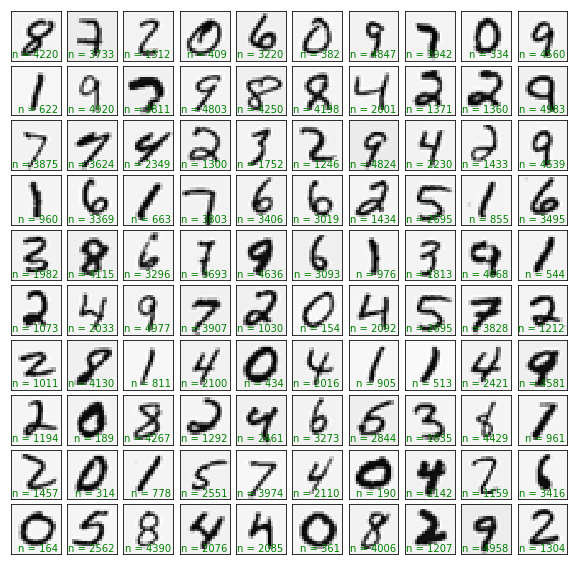

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    rand_n = np.random.randint(5000)
    im = X[rand_n, :]

    ax.imshow(im.reshape((20, 20), order='F'), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(rand_n + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

## Model Representation

Our neural network has 3 layers - an input layer, a
hidden layer and an output layer. Our inputs are pixel values of
digit images. Since the images are of size 20x20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). 

We already have a set of network parameters ($\Theta^{(1)}$,$\Theta^{(2)}$). These are stored in 'weights.mat' and will be
loaded into Theta1 and Theta2. The parameters have dimensions
that are sized for a neural network with 25 units in the second layer and 10
output units (corresponding to the 10 digit classes).

![title](picture.png)

## Feed Forward and Regularized Cost Function

First we will implement the cost function and gradient for the neural network. The cost function for the neural network (with regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)})log(1 - (h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m} \bigg[ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta^{(1)}_{j,k})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta^{(2)}_{j,k})^2 \bigg] $$

where $h_\theta(x^{(i)})$ is computed as shown in the figure above and K = 10 is the total
number of possible labels. Note that $h_\theta(x^{(i)})_k = a^{(3)}$ is the activation (output
value) of the k-th output unit. The original labels
(in the variable y) are 1, 2, ..., 10 but for the purpose of training a neural
network, we need to recode the labels as vectors containing only values 0 or
1, so that:

$$ y = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \end{bmatrix} $$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding
$y^{(i)}$ (that we should use with the cost function) should be a 10-dimensional
vector with $y_5$ = 1, and the other elements equal to 0.
We should implement the feedforward computation that computes $h_\theta(x^{(i)})$
for every example 'i' and add the cost over all examples. We also need to make sure that our code works for a dataset of any size, with any number of labels.

We assume that the neural network will only have 3 layers - an input
layer, a hidden layer and an output layer. However, our code should work
for any number of input units, hidden units and outputs units.

Now we will recode the labels to binary values using OneHot Encoder 

In [5]:
# Use OneHotEncoder to convert 'y' into 5000x10 matrix
OH_encoder = OneHotEncoder(sparse=False)  
y_new = OH_encoder.fit_transform(y)  
y_new.shape

(5000, 10)

In [6]:
# Define Sigmoid function
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

In [7]:
# Define the Regularized Cost function 
def costRegularized(Theta1, Theta2, input_size, hidden_size, num_labels, X, y, lambda_reg):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    J = 0
    
    #theta1 = np.matrix(np.reshape(nn_params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    #theta2 = np.matrix(np.reshape(nn_params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    theta1 = Theta1
    theta2 = Theta2
    
    # Feed Forward Algorithm
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)   # h is (5000 x 10) matrix
    
    # Computing Cost
    for i in range(m):
        first = np.multiply(-y[i,:], np.log(h[i,:]))
        second = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J = J + np.sum(first - second)

    J = (1/m) * J
    
    # Add Regularization
    reg = (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    J = J + reg
    
    return J


In [8]:
# Assign initial values
input_size = 400  
hidden_size = 25  
num_labels = 10  
learning_rate = 1

m = X.shape[0]  
X = np.matrix(X)  
y = np.matrix(y)

# If the 'weights2.mat' file with parameter values is not available, then use the following code to randomly initialize a parameter array of the size of the full network's parameters
#nn_params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25
#nn_params.shape

In [9]:
weights = loadmat('weights2.mat')  
weights

{'Theta1': array([[ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
          -1.30529929e-05,  -5.04175101e-06,   2.80464449e-09],
        [ -9.83811294e-02,   7.66168682e-09,  -9.75873689e-09, ...,
          -5.60134007e-05,   2.00940969e-07,   3.54422854e-09],
        [  1.16156052e-01,  -8.77654466e-09,   8.16037764e-09, ...,
          -1.20951657e-04,  -2.33669661e-06,  -7.50668099e-09],
        ..., 
        [ -1.83220638e-01,  -8.89272060e-09,  -9.81968100e-09, ...,
           2.35311186e-05,  -3.25484493e-06,   9.02499060e-09],
        [ -7.02096331e-01,   3.05178374e-10,   2.56061008e-09, ...,
          -8.61759744e-04,   9.43449909e-05,   3.83761998e-09],
        [ -3.50933229e-01,   8.85876862e-09,  -6.57515140e-10, ...,
          -1.80365926e-06,  -8.14464807e-06,   8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.05778129,
         -2.20823629,  0.56383834,  1.21105294,  2.21030997,  0.44456156,
         -1.18244872,  1

In [10]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
Theta1.shape, Theta2.shape, X.shape

((25, 401), (10, 26), (5000, 400))

In [11]:
# Use this function call, if 'weights2.mat' is not available
#costRegularized(nn_params, input_size, hidden_size, num_labels, X, y_new, learning_rate)

In [12]:
cost_0 = costRegularized(Theta1, Theta2, input_size, hidden_size, num_labels, X, y_new, learning_rate)
print('Regularized Cost calculated using Theta1 and Theta2 is {0}'.format(cost_0))

Regularized Cost calculated using Theta1 and Theta2 is 0.3837698590909235


## Backpropagation

Now we will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once we have computed the gradient, we will be able
to train the neural network by minimizing the cost function $J(\Theta)$ using an
advanced optimizer such as fmin_tnc.

Lets first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as:

$$ g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z)) $$ 

where,

$$ sigmoid(z) = g(z) = \frac{1}{1+e^{-z}} $$

In [13]:
def sigmoid_gradient(z):  
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

### Random Initialization of parameters

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$.

In [14]:
nn_params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25
nn_params.shape

(10285,)

### Defining function to implement Backpropagation

Now, we will implement the backpropagation algorithm. The intuition behind the backpropagation algorithm is as follows: 

Given a training example (x(t), y(t)), we will first run a 'forward pass' to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node j in layer l, we would like to compute an **error term** $\delta_j^{(l)}$ that measures how much that node was 'responsible' for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, we need to compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer (l + 1).

The following steps show in detail how the backpropagation algorithm works. We need to implement steps 1 to 4 in a loop that processes one example at a time. Concretely, we should implement a for-loop for **t = 1:m** and place steps 1-4 inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example (x(t), y(t)). Step 5 will divide the accumulated gradients by 'm' to obtain the gradients for the neural network cost function.

1. Set the input layer's values (a(1)) to the $t^{th}$ training example x(t). Perform a feedforward pass, computing the activations (z(2), a(2), z(3), a(3)) for layers 2 and 3. Note that we need to add a +1 term to ensure that the vectors of activations for layers a(1) and a(2) also include the bias unit.

2. For each output unit k in layer 3 (the output layer), set
$$ \delta_k^{(3)} = (a_k^{(3)} - y_k) $$
    where $y_k \in$ {0,1} indicates whether the current training example belongs to class k ($y_k$ = 1), or if it belongs to a different class ($y_k$ = 0).

3. For the hidden layer l = 2, set
$$ \delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)}.* g'(z^{(2)}) $$

4. Accumulate the gradient from this example using the following formula. Note that we need to skip or remove \delta_0^{(2)}.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by (1/m):
$$ \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} $$



In [15]:
def backprop(nn_params, input_size, hidden_size, num_labels, X, y, learning_rate):  
    
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    J = 0

    # Reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(nn_params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(nn_params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    # Feed Forward Algorithm
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)   # h is (5000 x 10) matrix

    delta1 = np.zeros(theta1.shape)  # (25 x 401) matrix
    delta2 = np.zeros(theta2.shape)  # (10 x 26) matrix

    # Compute the cost
    for i in range(m):
        first = np.multiply(-y[i,:], np.log(h[i,:]))
        second = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J = J + np.sum(first - second)

    J = (1/m) * J

    # Add the cost regularization term
    reg = (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    J = J + reg
    
    # Perform Backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1 x 401)
        z2t = z2[t,:]  # (1 x 25)
        a2t = a2[t,:]  # (1 x 26)
        ht = h[t,:]    # (1 x 10)
        yt = y[t,:]    # (1 x 10)

        d3t = ht - yt  # (1 x 10)

        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1 x 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1 x 26)

        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    # Add regularization term for gradient
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m

    # Unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return J, grad
    

In [16]:
J, grad = backprop(nn_params, input_size, hidden_size, num_labels, X, y_new, learning_rate)  

print('Cost = {0}'.format(J))
print('Shape of Gradient = {0}'.format(grad.shape))

Cost = 6.692123300485546
Shape of Gradient = (10285,)


### Learning parameters using fmincg

After successfully implementing the neural network cost function
and gradient computation, the next step is to use fmin_tnc
to learn a good set of parameters.

In [17]:
# Minimize the objective function
fmin = minimize(fun=backprop, x0=nn_params, args=(input_size, hidden_size, num_labels, X, y_new, learning_rate),  
                method='TNC', jac=True, options={'maxiter': 250})
fmin  

     fun: 0.34069092286668445
     jac: array([ -4.42582516e-05,  -4.57140237e-07,   4.53508463e-07, ...,
        -9.14160384e-05,   4.49938553e-05,  -3.81758244e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([ -2.23068780e-01,  -2.28570119e-03,   2.26754231e-03, ...,
        -1.74891709e+00,  -7.22320497e-01,  -3.33870482e+00])

We put a bound on the number of iterations since the objective function is not likely to completely converge. Our total cost has dropped below 0.5 which is a good indicator that the algorithm is working. Let's use the parameters it found and forward-propagate them through the network to get some predictions. We have to reshape the output from the optimizer to match the shapes of parameter matrix that our network is expecting, then run the forward propagation to generate a hypothesis for the input data.

### Predict and Calculate Accuracy

In [18]:
X = np.matrix(X)  
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))  
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

# Feed Forward Algorithm
a1 = np.insert(X, 0, values=np.ones(m), axis=1)
z2 = a1 * theta1.T
a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
z3 = a2 * theta2.T
h = sigmoid(z3)   # h is (5000 x 10) matrix
    
prediction = np.array(np.argmax(h, axis=1) + 1)  
correct = [1 if a == b else 0 for (a, b) in zip(prediction, y)]  
accuracy = (sum(map(int, correct)) / float(len(correct)))  
print('Accuracy is {0}%'.format(accuracy * 100))

Accuracy is 99.11999999999999%


It is possible to get higher training accuracies by training the neural network for more iterations. We can train the network for more iterations (e.g., set MaxIter to 400) and also vary the regularization parameter lambda. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.